#### 1. 利用上周NER模型训练任务代码，复现课堂案例中：动态学习率、混合精度、DDP训练实现。


In [ ]:
from transformers import AutoModelForTokenClassification, AutoTokenizer,DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import torch
import evaluate  
import seqeval  
from datasets import load_dataset


In [ ]:
#加载数据集
ds = load_dataset("doushabao4766/msra_ner_k_V3")


In [ ]:
ds['train']
for row in ds['train']:
    print(row)
    print(row['tokens'])
    print(row['ner_tags'])
    break
    

## 实体映射数据集词典准备

In [ ]:
tag_id = set()
for items in ds['train']:
    tag_id.update(items['ner_tags'])

tag_id

In [ ]:
# entity_index
entites = ['O'] + list({'PER', 'LOC', 'ORG'})
tags = ['O']
for entity in entites[1:]:
    tags.append('B-' + entity.upper())
    tags.append('I-' + entity.upper())

entity_index = {entity:i for i, entity in enumerate(entites)}

In [ ]:
tokenizer =AutoTokenizer.from_pretrained('google-bert/bert-base-chinese')

# 原始文本转换模型需要token_idx,生成和token_idx对齐label
def data_input_proc(item):

    # 输入文本先拆分为字符，再转换为模型输入的token索引
    batch_texts = [list(text) for text in item['tokens']]
    # 导入拆分为字符的文本列表时，需要设置参数is_split_into_words=True
    input_data = tokenizer(batch_texts, truncation=True, add_special_tokens=False, max_length=512, 
                           is_split_into_words=True, padding='max_length')
    # input_data['labels'] = [tag + [0] * (512 - len(tag)) for tag in item['ner_tags']]
    input_data['labels'] = [tag[:512] + [0] * (512 - len(tag[:512])) for tag in item['ner_tags']]
    return input_data
    
    

ds1 = ds.map(data_input_proc, batched=True)  # batched 每次传入自定义方法样本数量多个

In [ ]:
ds1.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

## 动态学习率


In [ ]:
# dataLoader
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
import torch.optim as optim

train_dl = DataLoader(ds1['train'], shuffle=True, batch_size=16)

# model
id2lbl = {i:tag for i, tag in enumerate(tags)}
lbl2id = {tag:i for i, tag in enumerate(tags)}


model = AutoModelForTokenClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                        num_labels=len(tags),
                                                        id2label=id2lbl,
                                                        label2id=lbl2id)

model.to('cuda')

# 模型参数分组
param_optimizer = list(model.named_parameters())
bert_params, classifier_params = [],[]

for name,params in param_optimizer:
    if 'bert' in name:
        bert_params.append(params)
    else:
        classifier_params.append(params)

param_groups = [
    {'params':bert_params, 'lr':1e-5},
    {'params':classifier_params, 'weight_decay':0.1, 'lr':1e-3}
]

# optimizer
optimizer = optim.AdamW(param_groups) # 优化器

# 学习率调度器
train_steps = len(train_dl) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=100, 
                                            num_training_steps=train_steps)


In [ ]:
from tqdm import tqdm
import torch

DEVICE='cuda'

#梯度计算缩放器
scaler = torch.GradScaler()

for epoch in range(5):
    model.train()
    tpbar = tqdm(train_dl)
    for items in tpbar:
        items = {k:v.to(DEVICE) for k,v in items.items()}
        # for key, value in items.items():
        #     print(f"Key: {key}, Shape: {value.shape}")
        optimizer.zero_grad()
        with torch.autocast(device_type='cuda'):
            outputs = model(**items)
        loss = outputs.loss

        #缩放loss后，调用backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
    
        tpbar.set_description(f'Epoch:{epoch+1} ' + 
                          f'bert_lr:{scheduler.get_lr()[0]} ' + 
                          f'classifier_lr:{scheduler.get_lr()[1]} '+
                          f'Loss:{loss.item():.4f}')

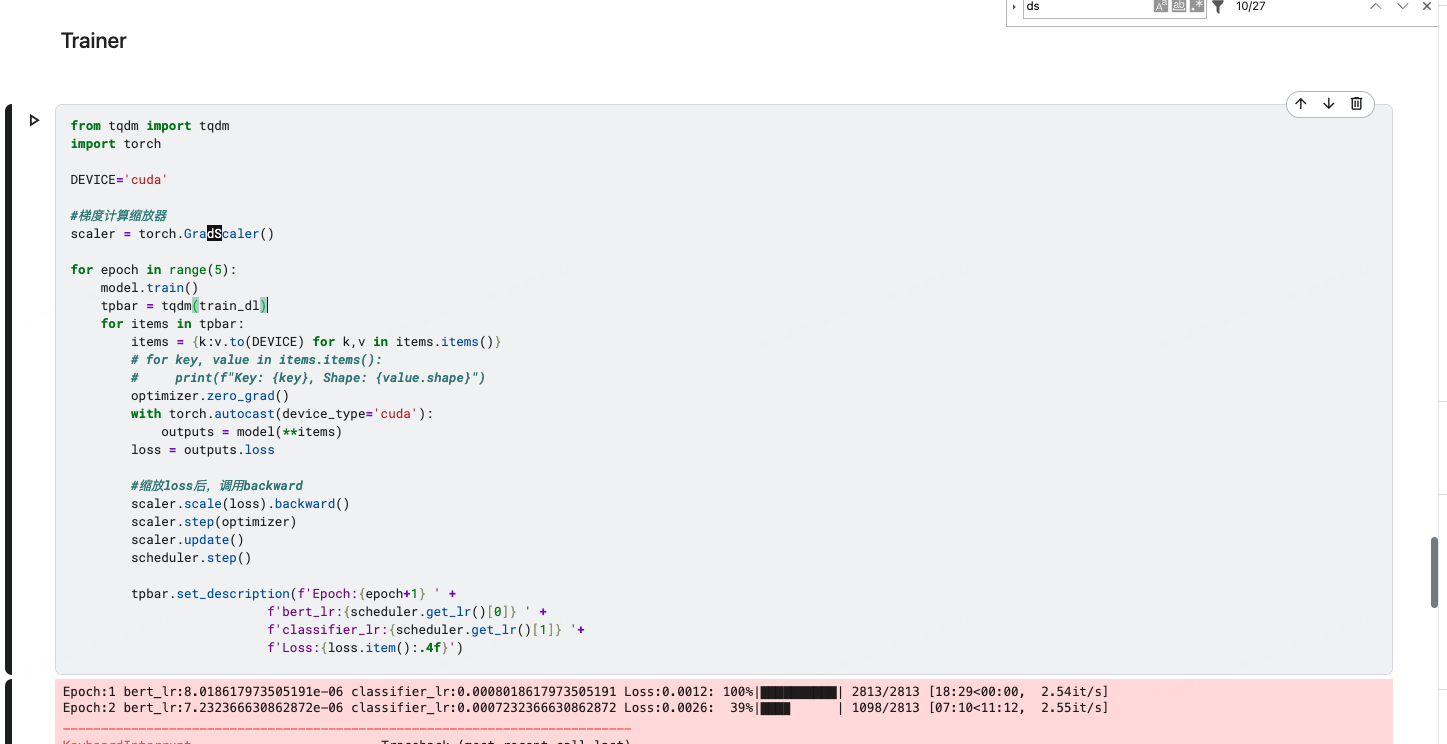

## 分布式ddp训练

In [ ]:
%%writefile ddp_ner.py

import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler
from transformers import AutoModelForTokenClassification, AutoTokenizer,DataCollatorForTokenClassification
from transformers import TrainingArguments, Trainer
import torch
import evaluate  
import seqeval  
from datasets import load_dataset



# 设置分布式环境
def setup(rank, world_size):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '12355'
    dist.init_process_group("nccl", rank=rank, world_size=world_size)


# 清理分布式环境
def cleanup():
    dist.destroy_process_group()


# 定义训练循环
def train(rank, world_size):
    setup(rank, world_size)
    
    ds = load_dataset("doushabao4766/msra_ner_k_V3")
    
    tag_id = set()
    for items in ds['train']:
        tag_id.update(items['ner_tags'])
    entites = ['O'] + list({'PER', 'LOC', 'ORG'})
    tags = ['O']
    for entity in entites[1:]:
        tags.append('B-' + entity.upper())
        tags.append('I-' + entity.upper())

    entity_index = {entity:i for i, entity in enumerate(entites)}
    
    tokenizer =AutoTokenizer.from_pretrained('google-bert/bert-base-chinese')

    def data_input_proc(item):
        # 输入文本先拆分为字符，再转换为模型输入的token索引
        batch_texts = [list(text) for text in item['tokens']]
        # 导入拆分为字符的文本列表时，需要设置参数is_split_into_words=True
        input_data = tokenizer(batch_texts, truncation=True, add_special_tokens=False, max_length=512, 
                               is_split_into_words=True, padding='max_length')
        # input_data['labels'] = [tag + [0] * (512 - len(tag)) for tag in item['ner_tags']]
        input_data['labels'] = [tag[:512] + [0] * (512 - len(tag[:512])) for tag in item['ner_tags']]  #tag[:512] 解决长度超过512的问题
        return input_data

    ds1 = ds.map(data_input_proc, batched=True)  # batched 每次传入自定义方法样本数量多个
    ds1.set_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

    local_rank = rank

    id2lbl = {i:tag for i, tag in enumerate(tags)}
    lbl2id = {tag:i for i, tag in enumerate(tags)}
    
    model = AutoModelForTokenClassification.from_pretrained('google-bert/bert-base-chinese', 
                                                        num_labels=len(tags),
                                                        id2label=id2lbl,
                                                        label2id=lbl2id)

    model.to(local_rank)

    args = TrainingArguments(
        output_dir="ner_train",  # 模型训练工作目录（tensorboard，临时模型存盘文件，日志）
        num_train_epochs = 3,    # 训练 epoch
        save_safetensors=False,  # 设置False保存文件可以通过torch.load加载
        per_device_train_batch_size=16,  # 训练批次
        per_device_eval_batch_size=16,
        report_to='tensorboard',  # 训练输出记录
        eval_strategy="epoch",
        local_rank=local_rank,   # 当前进程 RANK
        fp16=True,               # 使用混合精度
        lr_scheduler_type='linear',  # 动态学习率
        warmup_steps=100,        # 预热步数
        ddp_find_unused_parameters=False  # 优化DDP性能
    )
    
    def compute_metric(result):
        # result 是一个tuple (predicts, labels)
        
        # 获取评估对象
        seqeval = evaluate.load('seqeval')
        predicts,labels = result
        predicts = np.argmax(prdicts, axis=2)
        
        # 准备评估数据
        predicts = [[tags[p] for p,l in zip(ps,ls) if l != -100]
                     for ps,ls in zip(predicts,labels)]
        labels = [[tags[l] for p,l in zip(ps,ls) if l != -100]
                     for ps,ls in zip(predicts,labels)]
        results = seqeval.compute(predictions=predicts, references=labels)
    
        return results

    data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

    trainer = Trainer(
        model,
        args,
        train_dataset=ds1['train'],
        eval_dataset=ds1['test'],
        data_collator=data_collator,
        compute_metrics=compute_metric
    )
    
    trainer.train()



def main():
    world_size = torch.cuda.device_count()
    mp.spawn(train, args=(world_size,), nprocs=world_size, join=True)

if __name__ == "__main__":
    main()



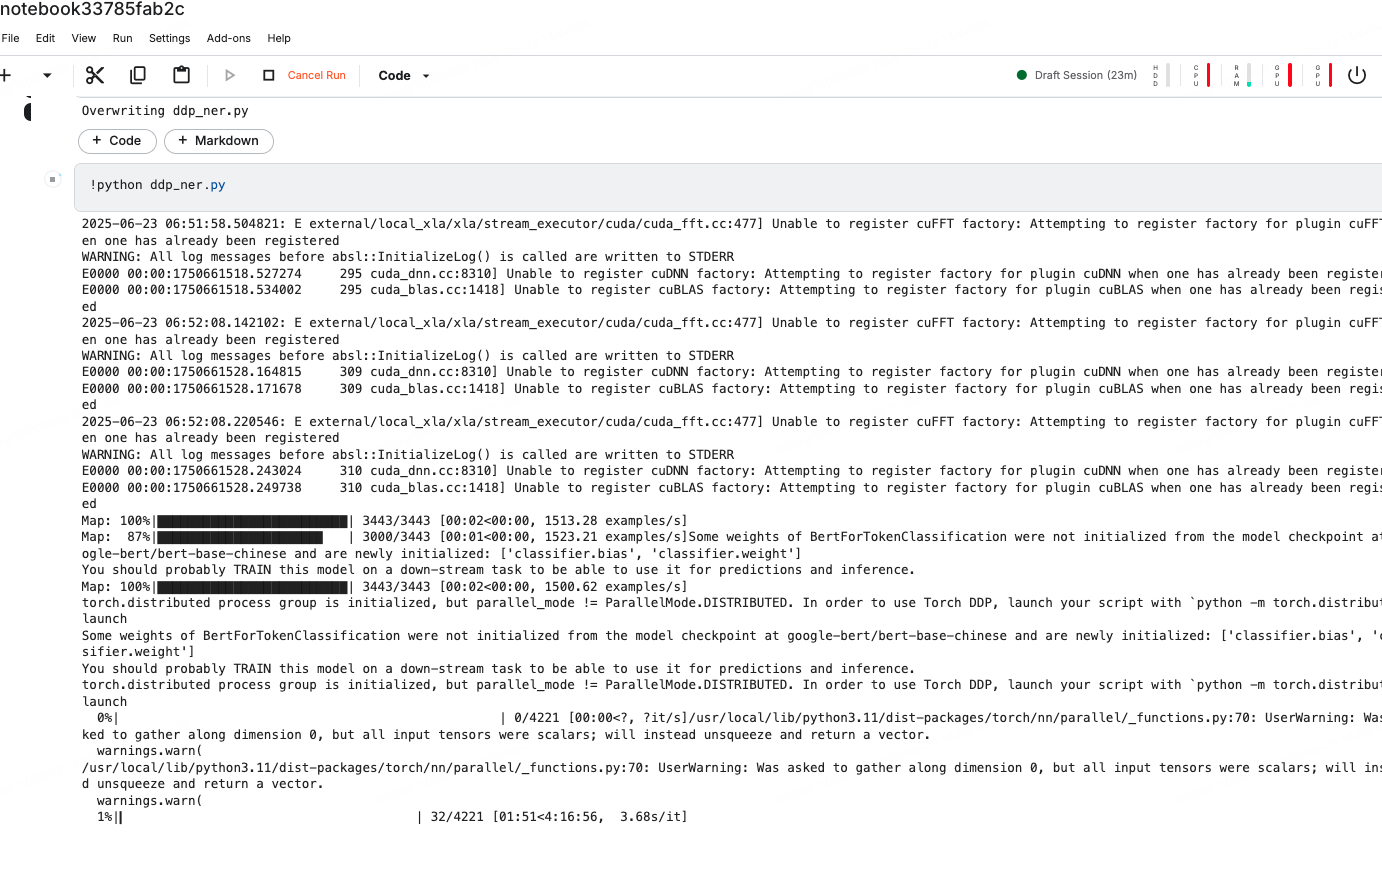